# Notebook 05: Modelado Predictivo

**Objetivo:** Entrenar un modelo de Machine Learning capaz de predecir el consumo eléctrico mensual por comuna, basándose en variables climáticas, socioeconómicas y temporales.

**Estrategia:**
1. **Split Temporal:** Entrenar con datos hasta 2022, testear con 2023 en adelante. Prohibido mirar el futuro.
2. **Modelo:** Usaremos **XGBoost** (o Random Forest), ya que maneja bien la no-linealidad del clima (la "curva en U" del consumo) y las interacciones complejas entre ingresos y temperatura.
3. **Evaluación:** Usaremos MAE (Error Absoluto Medio) para saber cuántos kWh nos equivocamos en promedio, y R2 para ver qué tan bien explicamos la varianza.

**Input:** `data/processed/master_table.csv`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
# Si tienes xgboost instalado, úsalo. Si no, RandomForest es un buen backup.
try:
    from xgboost import XGBRegressor
    MODEL_TYPE = 'XGBoost'
except ImportError:
    MODEL_TYPE = 'RandomForest'

# --- CONFIGURACIÓN ---
DATA_PATH = os.path.join('..', 'data', 'processed', 'master_table.csv')
sns.set_theme(style="whitegrid")

## 1. Preparación de Datos para el Modelo

In [2]:
print(">>> Cargando Master Table...")
df = pd.read_csv(DATA_PATH)
df['fecha'] = pd.to_datetime(df['fecha'])

# 1. Selección de Features (X) y Target (y)
# Quitamos columnas que no son predictores (como 'fecha' directa, o IDs)
features = [
    'mes', 'anio',                    # Temporalidad
    'hdd_acumulado', 'cdd_acumulado', # Clima (Impacto directo)
    'ingreso_promedio', 'tasa_pobreza', # Socioeconómico
    'clientes_facturados',            # Escala del consumo (Importante)
    'comuna_norm', 'tarifa'           # Categoróricas
]
target = 'energia_kwh'

df_model = df[features + [target, 'fecha']].copy()

# 2. Codificación de Categóricas (Label Encoding)
# Los árboles de decisión manejan bien los números enteros como categorías
le_comuna = LabelEncoder()
df_model['comuna_code'] = le_comuna.fit_transform(df_model['comuna_norm'])

le_tarifa = LabelEncoder()
df_model['tarifa_code'] = le_tarifa.fit_transform(df_model['tarifa'].astype(str))

# Actualizar lista de features
features_final = [
    'mes', 'anio', 
    'hdd_acumulado', 'cdd_acumulado', 
    'ingreso_promedio', 'tasa_pobreza',
    'clientes_facturados',
    'comuna_code', 'tarifa_code'
]

print(f"Features seleccionadas: {len(features_final)}")
print(df_model[features_final].head(3))

>>> Cargando Master Table...
Features seleccionadas: 9
   mes  anio  hdd_acumulado  cdd_acumulado  ingreso_promedio  tasa_pobreza  \
0    1  2015            0.0            1.4     433745.237559      0.036145   
1    1  2015            0.0            1.4     433745.237559      0.036145   
2    1  2015            0.0            1.4     433745.237559      0.036145   

   clientes_facturados  comuna_code  tarifa_code  
0                  1.0           25           14  
1                 55.0           25           13  
2                411.0           25           12  


## 2. División Temporal (Train/Test Split)
Cortamos los datos en el tiempo. No usamos azar.

In [3]:
# Definir fecha de corte (Por ejemplo, últimos 12-18 meses para test)
fecha_corte = '2023-01-01'

train = df_model[df_model['fecha'] < fecha_corte]
test = df_model[df_model['fecha'] >= fecha_corte]

X_train = train[features_final]
y_train = train[target]

X_test = test[features_final]
y_test = test[target]

print(f"Train set: {train.shape[0]} registros (Hasta 2022)")
print(f"Test set:  {test.shape[0]} registros (2023 en adelante)")

Train set: 59181 registros (Hasta 2022)
Test set:  14996 registros (2023 en adelante)


## 3. Entrenamiento del Modelo
Usamos XGBoost (o Random Forest) por su capacidad de capturar patrones no lineales complejos.

In [4]:
print(f">>> Entrenando {MODEL_TYPE}...")

if MODEL_TYPE == 'XGBoost':
    model = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        random_state=42,
        n_jobs=-1
    )
else:
    model = RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )

model.fit(X_train, y_train)
print("✅ Modelo entrenado.")

>>> Entrenando XGBoost...
✅ Modelo entrenado.


## 4. Evaluación y Métricas
¿Qué tan bueno es el modelo prediciendo el futuro?

--- Resultados en Test Set (2023-01-01 en adelante) ---
R2 Score: 0.9788 (¿Qué tanto explicamos la varianza? 1.0 es perfecto)
MAE:      235,747 kWh (Error promedio en unidades de energía)
MAPE:     inf% (Porcentaje de error promedio)


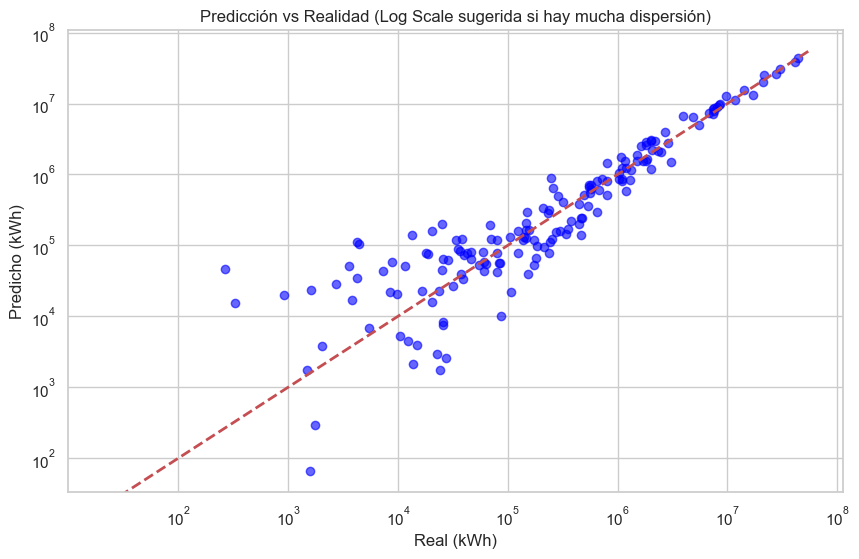

In [5]:
# Predicciones
y_pred = model.predict(X_test)

# Métricas
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"--- Resultados en Test Set ({fecha_corte} en adelante) ---")
print(f"R2 Score: {r2:.4f} (¿Qué tanto explicamos la varianza? 1.0 es perfecto)")
print(f"MAE:      {mae:,.0f} kWh (Error promedio en unidades de energía)")
print(f"MAPE:     {mape:.2f}% (Porcentaje de error promedio)")

# Gráfico de Predicción vs Realidad (Muestra aleatoria para no saturar)
plt.figure(figsize=(10, 6))
muestra = np.random.choice(len(y_test), size=min(200, len(y_test)), replace=False)
plt.scatter(y_test.iloc[muestra], y_pred[muestra], alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Línea perfecta
plt.xlabel("Real (kWh)")
plt.ylabel("Predicho (kWh)")
plt.title("Predicción vs Realidad (Log Scale sugerida si hay mucha dispersión)")
plt.xscale('log'); plt.yscale('log')
plt.show()

## 5. Importancia de Variables
¿Qué factores pesan más en la decisión del modelo?

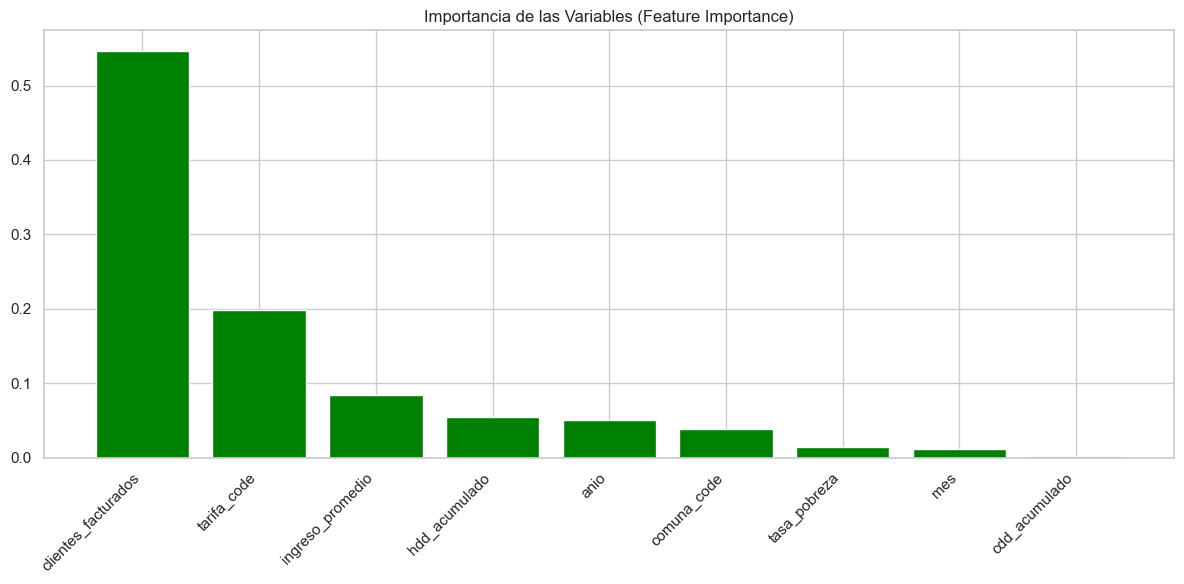


Interpretación: Si 'clientes_facturados' es la #1, es obvio (más gente = más consumo).
Lo interesante es ver dónde quedan HDD (Frío) y CDD (Calor) frente al Ingreso.


In [6]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Importancia de las Variables (Feature Importance)")
plt.bar(range(X_train.shape[1]), importances[indices], align="center", color='green')
plt.xticks(range(X_train.shape[1]), [features_final[i] for i in indices], rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nInterpretación: Si 'clientes_facturados' es la #1, es obvio (más gente = más consumo).")
print("Lo interesante es ver dónde quedan HDD (Frío) y CDD (Calor) frente al Ingreso.")